In [93]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from torchvision.utils import save_image
import sys
from torch.autograd import Variable

In [94]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False,transform=transforms.ToTensor())

In [95]:
train_data = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=64, 
                                           shuffle=True)
 
test_data = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=64, 
                                          shuffle=False)

In [96]:
class VAE(nn.Module):
    def __init__(self):
        #Encoder
        super(VAE, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc_mu = nn.Linear(400, 20)
        self.fc_sig = nn.Linear(400, 20)
    
    
        self.Decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.ReLU()
            nn.Linear(400, 784),
            nn.Sigmoid() 
        )
    
    def hidden_state_representation(self, mu, sig):
        error = Variable(torch.randn(mu.size(0),mu.size(1)))
        z = mu + error  * torch.exp(sig/2)  
        return z

    def forward(self, x):
        y1 = self.Encoder(x)
        y2 = self.Encoder(x)
        mu = self.fc_mu(y1)
        sig = self.fc_sig(y2)
        z = self.hidden_state_representation(mu, sig)
        out = self.Decoder(z)
        return out,mu,sig

In [97]:
vae = VAE()

In [98]:
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [99]:
num_epochs = 10

In [101]:
loss_list = []
for epoch in range(num_epochs):
    loss_sum_in_epoch = 0
    for step,(x, _) in enumerate(train_data):
        if (x.shape[0] != 64):
            continue
        x = x.reshape(64,784)
        vae_outputs = vae(x)
        loss = criterion(vae_outputs[0], x) - 0.5 * torch.sum(1 + vae_outputs[1] - vae_outputs[1].pow(2) - vae_outputs[2].exp())
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum_in_epoch = loss_sum_in_epoch + loss.item()
    loss_list.append(loss_sum_in_epoch/937)
    print('Epoch[{}/{}]'.format(epoch+1,num_epochs))

Epoch[1/10]
Epoch[2/10]
Epoch[3/10]
Epoch[4/10]
Epoch[5/10]
Epoch[6/10]
Epoch[7/10]
Epoch[8/10]
Epoch[9/10]
Epoch[10/10]


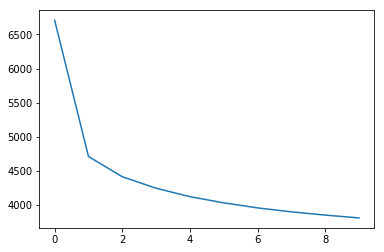

In [102]:
Loss_df = pd.DataFrame({'index': list(range(10)), 'Loss': loss_list})
plt.plot('index', 'Loss', data=Loss_df)

In [104]:
iterator = iter(test_data)
x_test, label = iterator.next()
x_test = x_test.reshape(64,784)
vae_outputs = vae(x_test)[0]
vae_outputs = vae_outputs.reshape(64,1,28,28)
vae_sample = vae_outputs[:16].reshape(vae_outputs[:16].size(0), 1, 28, 28)
save_image(vae_sample, 'VAE_out.png',nrow=4)

In [92]:
torch.save(vae.state_dict(), 'hw5_vae.pth')